# Coursework 3

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

In [15]:
import numpy
from scipy.integrate import quad
from matplotlib import pyplot

%matplotlib inline

## Stochastic Differential Equations - Ornstein-Ühlenbeck problem

Consider the Ornstein-Uhlenbeck problem
$$
  \text{d}X = -\lambda X \, \text{d}t + \mu \, \text{d}W.
$$

Its solution is
$$
  X(t) = e^{-\lambda t} X_0 + \mu \int_0^t e^{-\lambda (t - s)} \, \text{d}W(s).
$$

In addition, we can calculate $\mathbb{E}(X)$ and $\mathbb{E}(X^2)$ as
$$
\begin{align}
  \mathbb{E}(X) & = e^{-\lambda t} X_0, \\
  \mathbb{E}(X^2) & = e^{-2\lambda t} X_0^2 + \frac{\mu^2}{2 \lambda} \left( 1 - e^{-2 \lambda t} \right).
\end{align}
$$
In particular we can show that
$$
  \lim_{t \to \infty} X \sim N \left( 0, \frac{\mu^2}{2 \lambda} \right):
$$
that is, for late enough time the solution follows a normal distribution.

### Tasks

1. Solve the Ornstein-Ühlenbeck problem using the Euler-Maruyama method. Use $X_0 = 1, \lambda=1, \mu=1$ and solve to end time $T=1$. Using $\delta t = 2^{- \left(4, \dots, 10\right)}$ check the weak order of convergence by looking at the error in $X^2$.
2. Plot a histogram of $X(10)$ for $10^5$ realizations with $\delta t = 2^{-7}$, using Euler-Maruyama. How is it distributed?
3. By computing the mean of $X^2(T)$ (which is the variance), check that 
$$
  X^{(h)}(T) \sim N \left( 0, \frac{\mu^2}{2 \lambda - \lambda^2 \, \delta t} \right)
$$
for $T=10$ (which is meant to represent "large" $T$).
4. Repeat these steps for the theta method
$$
  X_{n+1} = X_n - \lambda \, \delta t \, \theta X_{n+1} - \lambda \, \delta t \, (1 - \theta) X_n + \mu \, \text{d}W_n
$$
for $\theta=1/2$. Why is it different?

In [2]:
def rock_on(rockness = True):
    if rockness:
        print("\\m/(**)\\m/")
        
rock_on()

\m/(**)\m/


In [3]:
def x_exact(X0, t_range, l, u, dW):
    X = numpy.zeros_like(dW)
    dw0 = dW[0]
    for i, dw in enumerate(dW):
        X[i] = numpy.exp(-l * t_range[i]) * X0 + u / l * (dw - numpy.exp(-l * t_range[i]) * dw0)
        
    return X

In [4]:
def EM(X0, t_range, l, u, dW):
    X = numpy.zeros_like(dW)
    X[0] = X0
    dt = t_range[1] - t_range[0]
    W = numpy.zeros(dW.shape[0])
    
    for i, dw in enumerate(dW[:-1]):
        X[i+1] = X[i] - l * X[i] * dt + u * dw
        
    return X

In [5]:
def init_vals():
    X0 = 1
    l = 1
    u = 1
    T = 1
    return X0, l, u, T

In [6]:
def EX(X0, t_range, l):
    return numpy.exp(-l * t_range) * X0

In [7]:
def EX2(X0, t_range, l, u, dW):
    #E = numpy.zeros_like(dW)
    E = numpy.exp(-2 * l * t_range) * X0 * X0 + (u * u / (2 * l)) * (1 - numpy.exp(-2 * l * t_range))
    return E

### Task 1

In [13]:
def plot_graphs(start, end):
    X0, l, u, T = init_vals()
    dW = numpy.random.randn(2**end) 
    
    fig = pyplot.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    for i in range(start, end+1):
        N = 2**i
        dt = T/N
        dw = dW * numpy.sqrt(dt)
        t_range = numpy.linspace(dt, T, N)
        X = EM(X0, t_range, l, u, dw[::2**(end-i)])
        X2 = X**2
        ax1.plot(t_range[:], X[:], label=(r'X for $\delta$ t = {}'.format(dt)))
        ax2.plot(t_range, X2, label=r'X^2 for $\delta$ t = {}'.format(dt))
    
        
    eX = EX(X0, t_range, l)
    ax1.plot(t_range, eX, "k--", linewidth=3, label=r'$\mathbb{E}(X)$')
    eX2 = EX2(X0, t_range, l, u, dW * numpy.sqrt(dt)) 
    ax2.plot(t_range, eX2, "k--", linewidth=3, label=r'$\mathbb{E}(X^2)$')
    
    ax1.legend(loc='upper right', fontsize=9)
    ax2.legend(loc='upper right', fontsize=9)
    ax1.set_title(r'X & $\mathbb{E}(X)$ vs time $t$')
    ax2.set_title(r'X^2 & $\mathbb{E}(X^2)$ vs time $t$')
    ax1.set_xlabel(r'Time')
    ax2.set_xlabel(r'Time')
    ax1.set_ylabel(r'X, $\mathbb{E}(X)$')
    ax2.set_ylabel(r'X^2, $\mathbb{E}(X^2)$')        
    fig.show()

In [28]:
def weak(n, m):
    """
    n - array
        powers
    
    m - int
        number of representations"""
    X0, l, u, T = init_vals()
    no_power = n.shape[0]
    N = 2**n
    dt = 1/N
    DT = numpy.sqrt(dt)
    t_range = numpy.linspace(0, T, N[-1]+1)
    E_n = numpy.zeros_like(n)
    E_e = numpy.zeros_like(n)
    for i in range(m):
        dW = numpy.random.randn(N[-1]+1)
        
        for i in range(no_power):
            dw = dW * DT[i]
            E_n[i] += numpy.abs(EM(X0, t_range[::int(2**(n[-1] - n[i]))], 
                                   l , u, dw[::int(2**(n[-1] - n[i]))])[-1]**2)
            E_e[i] += numpy.abs(EX2(X0, t_range[-1],
                                    l , u, dw[-1]))
    
    E = abs(E_e/m - E_n/m)
    return E, dt

In [25]:
def plot_conver(Ninit, Nfinal, m):
    n = numpy.linspace(Ninit, Nfinal, Nfinal - Ninit + 1)
    E, h = weak(n, m)
    
    grad, e_pow = numpy.polyfit(numpy.log(h), numpy.log(E), 1)
    conv = numpy.exp(e_pow) * h**grad
    
    fig = pyplot.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    ax.loglog(h, E, 'kx', ms=10, lw=5, label="Error")
    ax.loglog(h, conv, linewidth=4, label="Convergence")
    ax.set_title(r"Convergence at ${:3f}$.".format(grad), fontsize=20)
    ax.set_xlabel(r"Time step, $\delta t$", fontsize=15)
    ax.set_ylabel(r"Error, avg($X^2 - \mathbb{E}(X^2)$)", fontsize=15)
    ax.legend(loc='upper right', fontsize=20)
    ax.grid(True, axis="both", which="both")
    fig.show()

/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


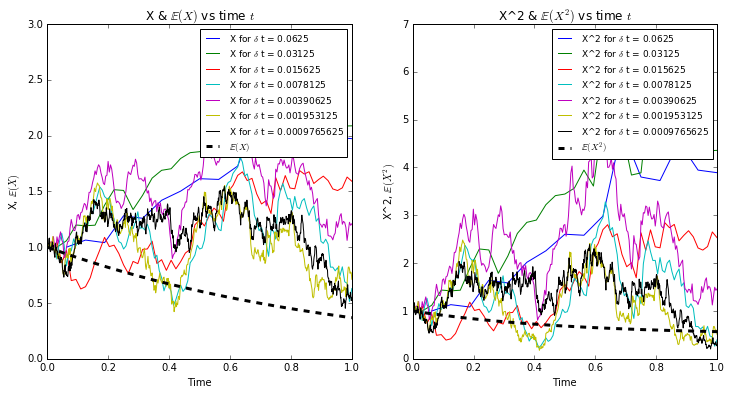

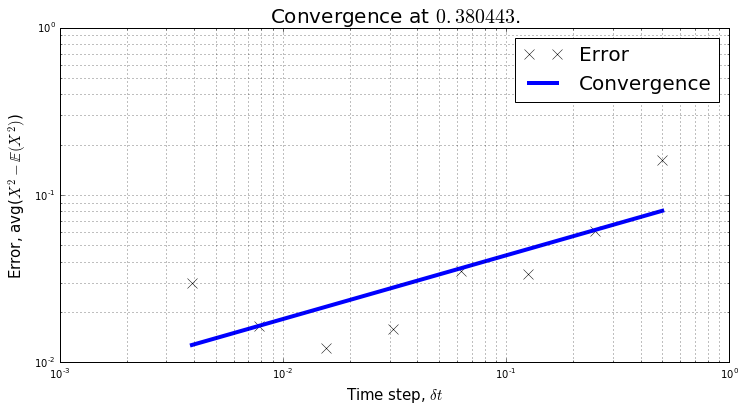

In [27]:
plot_graphs(4,10)
plot_conver(1, 8, 1000)

### Task 2 

In [42]:
def histogram_data(T, dt, realisations):
    X0, l, u, TT = init_vals()
    DT = numpy.sqrt(dt)
    N = int(T / dt)
    X = numpy.zeros(realisations)
    t_range = numpy.linspace(0, T, N+1)
    
    for i in range(realisations):
        dW = numpy.random.randn(N+1) * DT
        X[i] = EM(X0, t_range, l, u, dW)[-1]
    return X

In [38]:
def plot_histogram(results, bins):
    pyplot.figure(figsize=(12,6))
    pyplot.hist(results, bins)
    pyplot.title("Histogram")
    pyplot.xlabel("X values")
    pyplot.ylabel("Number of realisations")
    pyplot.show()

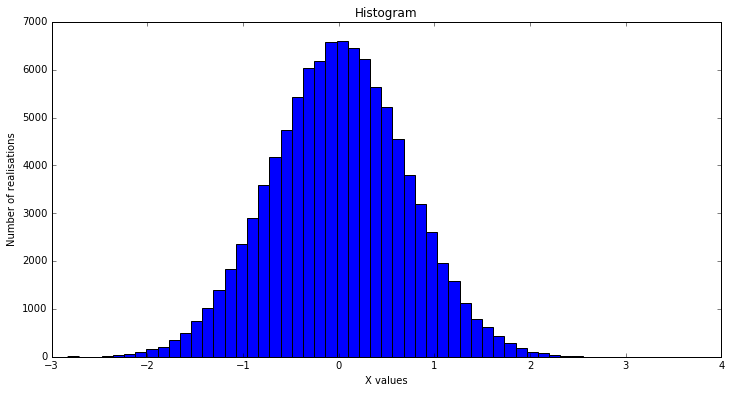

In [43]:
X = histogram_data(10, 2**-7, 10**5)
plot_histogram(X, 50)

## Self consistent fields - Water

Perform the self-consistent field calculation for a water molecule, $\text{H}_2\text{O}$.

### Parameters

The locations of the atoms are:

In [2]:
R_O = [0.0, 1.809*numpy.cos(104.52/180.0*numpy.pi/2.0), 0.0]
R_H1 = [-1.809*numpy.sin(104.52/180.0*numpy.pi/2.0), 0.0, 0.0]
R_H2 = [+1.809*numpy.sin(104.52/180.0*numpy.pi/2.0), 0.0, 0.0]

The nuclear repulsion energy is:

In [3]:
Vnn = 8.90770810

The overlap matrix is:

In [4]:
S = numpy.array([[ 1.       ,  0.2367039,  0.       ,  0.       , -0.       ,
         0.0500137,  0.0500137],
       [ 0.2367039,  1.       ,  0.       ,  0.       , -0.       ,
         0.4539953,  0.4539953],
       [ 0.       ,  0.       ,  1.       ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  1.       ,  0.       ,
         0.2927386, -0.2927386],
       [-0.       , -0.       ,  0.       ,  0.       ,  1.       ,
         0.2455507,  0.2455507],
       [ 0.0500137,  0.4539953,  0.       ,  0.2927386,  0.2455507,
         1.       ,  0.2510021],
       [ 0.0500137,  0.4539953,  0.       , -0.2927386,  0.2455507,
         0.2510021,  1.       ]])

The core Hamiltonian is:

In [5]:
H = numpy.array([[ -3.26850823e+01,  -7.60432270e+00,   0.00000000e+00,
          0.00000000e+00,  -1.86797000e-02,  -1.61960350e+00,
         -1.61960350e+00],
       [ -7.60432270e+00,  -9.30206280e+00,   0.00000000e+00,
          0.00000000e+00,  -2.22159800e-01,  -3.54321070e+00,
         -3.54321070e+00],
       [  0.00000000e+00,   0.00000000e+00,  -7.43083560e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -7.56702220e+00,   0.00000000e+00,  -1.89085610e+00,
          1.89085610e+00],
       [ -1.86797000e-02,  -2.22159800e-01,   0.00000000e+00,
          0.00000000e+00,  -7.52665570e+00,  -1.65878930e+00,
         -1.65878930e+00],
       [ -1.61960350e+00,  -3.54321070e+00,   0.00000000e+00,
         -1.89085610e+00,  -1.65878930e+00,  -4.95649010e+00,
         -1.56026360e+00],
       [ -1.61960350e+00,  -3.54321070e+00,   0.00000000e+00,
          1.89085610e+00,  -1.65878930e+00,  -1.56026360e+00,
         -4.95649010e+00]])

The number of electrons is:

In [6]:
Nelectrons = 10

The two electron integrals are given in the data file:

In [216]:
G=numpy.fromfile('./H2O-two-electron.dat')
G = numpy.reshape(G,(7,7,7,7));

### Plotting

There is useful information contained in the basis functions. The calculations here used the *STO-3G* basis, which are Gaussians with carefully chosen coefficients. There is one basis function per atomic orbital: so one for each hydrogen (the "1s" orbital) and five for the oxygen (one for the "1s" orbital, one for the "2s" orbital, and three for the "2p" orbitals - one for each Cartesian direction, associated with the quantum spins). Each basis function is written
$$
  \tilde{\chi} (r) = \sum_{i=1}^3 c_{i} \left( \frac{2 \alpha_i}{\pi} \right)^{3/4} e^{-\alpha_i r^2},
$$
where $r$ is the distance to the nucleus of this particular atom, and the $c_i, \alpha_i$ coefficients depend on the atom and the orbital.

For the "1s" orbitals the values of the coefficients are
$$
\begin{align}
  c_1 &= 0.444635, & c_2 &= 0.535328, & c_3 &= 0.154329, \\
  \alpha_1 &= 0.109818 \zeta_1^2, & \alpha_2 &= 0.405771 \zeta_1^2, & \alpha_3 &= 2.22766 \zeta_1^2.
\end{align}
$$
Here $\zeta_1 = 1.24$ for hydrogen and $\zeta_1 = 7.66$ for oxygen.

For the "2s" orbital the coefficients are
$$
\begin{align}
  c_1 &= 0.700115, & c_2 &= 0.399513, & c_3 &= -0.0999672, \\
  \alpha_1 &= 0.0751386 \zeta_2^2, & \alpha_2 &= 0.231031 \zeta_2^2, & \alpha_3 &= 0.994203 \zeta_2^2.
\end{align}
$$
Here $\zeta_2 = 2.25$ for oxygen.

Finally, for the "2p" orbital, the coefficients are
$$
\begin{align}
  c_1 &= 0.391957, & c_2 &= 0.607684, & c_3 &= 0.1559163, \\
  \alpha_1 &= 0.0751386 \zeta_2^2, & \alpha_2 &= 0.231031 \zeta_2^2, & \alpha_3 &= 0.994203 \zeta_2^2.
\end{align}
$$

In the above matrices, the seven entries correspond to:
$$
\begin{align}
  0 &: \text{Oxygen, 1s}, \\
  1 &: \text{Oxygen, 2s}, \\
  2 &: \text{Oxygen, 2p (x)}, \\
  3 &: \text{Oxygen, 2p (y)}, \\
  4 &: \text{Oxygen, 2p (z)}, \\
  5 &: \text{Hydrogen (1), 1s}, \\
  6 &: \text{Hydrogen (2), 1s}.
\end{align}
$$

### Constructing the full molecular orbitals

Given these basis functions, the single orbital molecular orbitals can be constructed as
$$
  \chi_i = \sum_{\mu=1}^K C_{i\mu} \tilde{\chi}_{\mu}.
$$
The iso-surfaces of the molecular orbitals give useful information about the reaction properties of the molecule.

### Tasks

1. Compute the total energy using the self-consistent field method. Ensure that your code prints the energy to the screen and returns the basis coefficients $C$ for later use.
2. Construct the molecular orbitals and plot isocontours of each in the $x-y$ plane.

### Task 1 

In [188]:
def transf_matrix(S):
    """
    Function that computes the transformation matrix X, given S the overlap matrix between the basis functions.
    
    Paramteres:
    S - numpy array  (N, N)
        the overlap matrix between the basis functions
        
    Returns
    X - numpy array (N, N)
        the transformation matrix
    """
    assert type(S) == numpy.ndarray, \
        "S is not a numpy array in transf_matrix. It is currently a {}.".format(type(S))
    assert S.shape[0] == S.shape[1], \
        "S must be a square matrix in transf_matrix. It's current shape is {}.".format(S.shape)
    Delta, U = numpy.linalg.eig(S)
    Delta = numpy.diag(Delta**(-1/2))
    X = numpy.dot(U, numpy.dot(Delta, numpy.conj(U).T))
    assert (X.shape == S.shape), \
        "X is not the same shape as S in transf_matrix. It's current shape is {}.".format(X.shape)
    return X

In [236]:
def density_matrix(C, N):
    """Function that computes the density matrix D, given the number of electrons and the 
    basis coefficients as a matrix C.
    
    Paramters
    C - numpy array (n, n)
        matrix containing the coefficients of the basis faunctions
        
    N - int
        number of electrons in the molecule
        
    Return 
    D - numpy array (n, n)
        matrix containing the density matrix in the field"""
    
    assert type(C) == numpy.ndarray, \
        "C is not a numpy array. It currently is {}.".format(type(C))
    assert C.shape[0] == C.shape[1], \
        "C is not a square matrix. It's currently shape is {}.".format(C.shape)
    assert type(N) == int or type(N) == numpy.int, \
        "N is not an integer. It currently is {}.".format(type(N))
    
    N_e = int(numpy.around(N/2+0.49))
    uv, n = C.shape
    D = numpy.zeros([uv, uv])
    for u in range(uv):
        for v in range(uv):
            for j in range(N_e):
                D[u, v] += 2 * C[u, j] * C[v, j]
    assert D.shape == C.shape, \
        "D was not properly created. It's current shape is {}.".format(D.shape)
    return D


In [171]:
def fock_matrix(H, G, D):
    """
    Function that computes the fock matrix.
    
    Paramters
    H - numpy array (N, N)
        matrix containing the one-electron integrals 
    G - numpy array (N, N) 
        matrix containing the two-electron integrals
    D - numpy array (n, n)
        matrix containing the density matrix in the field
        
    Return
    F - numpy array (N, N)
        matrix containing the fock matrix elements
    """
    assert type(H) == numpy.ndarray, \
        "H is not a numpy array. It currently is {}.".format(type(H))
    assert type(G) == numpy.ndarray, \
        "G is not a numpy array. It currently is {}.".format(type(G))
    assert type(D) == numpy.ndarray, \
        "D is not a numpy array. It currently is {}.".format(type(D))
    assert H.shape[0] == H.shape[1], \
        "H is not square matrix. It's current shape is {}.".format(H.shape)
    assert G.shape[0] == G.shape[1], \
        "G is not square matrix. It's current shape is {}.".format(G.shape)
    assert D.shape[0] == D.shape[1], \
        "D is not square matrix. It's current shape is {}.".format(D.shape)
    assert D.shape[0] == G.shape[0] and D.shape[0] == H.shape[0], \
        "H , G, D are not the same shape."
    miu, niu = H.shape
    alpha, beta = D.shape
    F = numpy.copy(H)
    for u in range(miu):
        for v in range(miu):
            for alpha in range(miu):
                for beta in range(miu):
                    F[u, v] += (G[u, v, alpha, beta] -
                                  0.5 * G[u, beta, alpha, v]) * D[alpha,
                                                                    beta]
    assert F.shape == H.shape, \
        "F was not created properly in fock_matrix. It's current shape is {}.".format(F.shape)
    assert (F.any != 0), \
        "F was not created properly in fock_matrix. It is a 0 matrix."
    
    return F

In [220]:
def orb_energya(F, X):
    """
    function which computes the new orbital energy and the matrix C containing the coefficients for the 
    basis functions.
    
    Parameters
    F - numpy array (N, N)
        matrix containing the fock matrix elements
    X - numpy array (N, N)
        the transformation matrix
    
    Return
    epsilon - numpy array (N,)
            array containing the orbital energies for the assumed layers
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions
    """
    assert type(F) == numpy.ndarray, \
        "F is not a numpy array. It currently is {}.".format(type(F))
    assert F.shape[0] == F.shape[1], \
        "F is not square matrix. It's current shape is {}.".format(F.shape)
    assert type(X) == numpy.ndarray, \
        "X is not a numpy array. It currently is {}.".format(type(X))
    assert X.shape[0] == X.shape[1], \
        "X is not square matrix. It's current shape is {}.".format(X.shape)
    
    
    F_p = numpy.dot(numpy.conj(X).T, numpy.dot(F, X))  
    epsilon, V = numpy.linalg.eigh(F_p)
    
    ID = numpy.argsort(epsilon)
    epsilon = epsilon[ID]
    V = V[:, ID]
    C = numpy.dot(X, V)
    
    assert epsilon.shape[0] == F.shape[0], \
        "epsilon does not have the correct shape. It curretly has {}.".format(epsilon.shape)
    assert C.shape[0] == F.shape[0] and C.shape[0] == C.shape[1], \
        "C is not a square matrix and the same shape as F&X. It's current shape is {}.".format(C.shape)
    return epsilon, C

In [198]:
def D_new(X, H, G, C, D, Ne):
    """
    Function that calculates a new desity matrix based on the old density matrix D.
    
    Parameters
    X - numpy array (N, N)
        the transformation matrix
    H - numpy array (N, N)
        matrix containing the one-electron integrals 
    G - numpy array (N, N) 
        matrix containing the two-electron integrals
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions
    D - numpy array (n, n)
        matrix containing the density matrix in the field
    Ne - int
        number of electrons in the molecule
        
    Return:
    D - numpy array (n, n)
        matrix containing the density matrix in the field
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions
    V - numpy array (N,)
            array containing the orbital energies for the assumed layers
    """
    assert type(X) == numpy.ndarray, \
        "X is not a numpy array. It currently is {}.".format(type(X))
    assert X.shape[0] == X.shape[1], \
        "X is not square matrix. It's current shape is {}.".format(X.shape)
    N = X.shape[0]
    assert type(H) == numpy.ndarray, \
        "H is not a numpy array. It currently is {}.".format(type(H))
    assert type(G) == numpy.ndarray, \
        "G is not a numpy array. It currently is {}.".format(type(G))
    assert type(D) == numpy.ndarray, \
        "D is not a numpy array. It currently is {}.".format(type(D))
    assert H.shape[0] == H.shape[1], \
        "H is not square matrix. It's current shape is {}.".format(H.shape)
    assert G.shape[0] == G.shape[1], \
        "G is not square matrix. It's current shape is {}.".format(G.shape)
    assert D.shape[0] == D.shape[1], \
        "D is not square matrix. It's current shape is {}.".format(D.shape)
    assert D.shape[0] == G.shape[0] and D.shape[0] == H.shape[0], \
        "H , G, D are not the same shape."
    assert type(C) == numpy.ndarray, \
        "C is not a numpy array. It currently is {}.".format(type(C))
    assert C.shape[0] == C.shape[1], \
        "C is not a square matrix. It's currently shape is {}.".format(C.shape)
    assert D.shape[0] == N, \
        "D is not the same shape as X. It is {}, while it should be {}.".format(D.shape, X.shape)
    assert H.shape[0] == N, \
        "H is not the same shape as X. It is {}, while it should be {}.".format(H.shape, X.shape)
    assert G.shape[0] == N, \
        "G is not the same shape as X. It is {}, while it should be {}.".format(G.shape, X.shape)
    assert C.shape[0] == N, \
        "C is not the same shape as X. It is {}, while it should be {}.".format(C.shape, X.shape)
    assert type(N) == int, \
        "N is not an int. It is {}.".format(type(N))
    
    F = fock_matrix(H, G, D)
    V, C = orb_energya(F, X)
    D = density_matrix(C, Ne)
    return D, C, V

In [201]:
def give_me_ma_energy(D, H, F, Vnn):
    """
    Function that returns the total energy of the configuration. 
    
    Parameters:
    D - numpy array (n, n)
        matrix containing the density matrix in the field
    H - numpy array (N, N)
        matrix containing the one-electron integrals 
    F - numpy array (N, N)
        matrix containing the fock matrix elements
    Vnn - float
        nucleon-nucleon interaction energy
        
    Return 
    Energy - float
        the total energy of the system
    """
    assert type(H) == numpy.ndarray, \
        "H is not a numpy array. It currently is {}.".format(type(H))
    assert type(F) == numpy.ndarray, \
        "F is not a numpy array. It currently is {}.".format(type(F))
    assert type(D) == numpy.ndarray, \
        "D is not a numpy array. It currently is {}.".format(type(D))
    assert H.shape[0] == H.shape[1], \
        "H is not square matrix. It's current shape is {}.".format(H.shape)
    assert F.shape[0] == F.shape[1], \
        "F is not square matrix. It's current shape is {}.".format(F.shape)
    assert D.shape[0] == D.shape[1], \
        "D is not square matrix. It's current shape is {}.".format(D.shape)
    N = D.shape[0]
    assert H.shape[0] == N, \
        "H is not the same shape as X. It is {}, while it should be {}.".format(H.shape, D.shape)
    assert F.shape[0] == N, \
        "F is not the same shape as X. It is {}, while it should be {}.".format(F.shape, D.shape)   
    assert type(Vnn) == int or type(Vnn) == float or type(Vnn) == numpy.float64, \
        "Vnn is not a recognised type. Current type is {}.".format(type(Vnn))
        
    return numpy.sum(D * (H + F)) / 2.0 + Vnn

In [287]:
def hartrees(S, H, G, Vnn, C, Ne = Nelectrons, tol = 1e-13):
    """
    Function which iterates the Hartree-Fock method until it converges to a certain tolerance. 
    It return the total energy of the system and the matrix C containing the coefficienct of the basis functions.
    
    Parameters:
    S - numpy array  (N, N)
        the overlap matrix between the basis functions
    H - numpy array (N, N)
        matrix containing the one-electron integrals 
    G - numpy array (N, N) 
        matrix containing the two-electron integrals
    Vnn - float
        nucleon-nucleon interaction energy
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions. I
    tol - float
        the tolerance to which the system should try and converge. 
        
    Return
    E - float
        the total energy of the configuration
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions. I
    """
    assert type(S) == numpy.ndarray, \
        "S is not a numpy array in transf_matrix. It is currently a {}.".format(type(S))
    assert S.shape[0] == S.shape[1], \
        "S must be a square matrix in transf_matrix. It's current shape is {}.".format(S.shape)
    assert type(H) == numpy.ndarray, \
        "H is not a numpy array. It currently is {}.".format(type(H))
    assert type(G) == numpy.ndarray, \
        "G is not a numpy array. It currently is {}.".format(type(G))
    assert H.shape[0] == H.shape[1], \
        "H is not square matrix. It's current shape is {}.".format(H.shape)
    assert G.shape[0] == G.shape[1], \
        "G is not square matrix. It's current shape is {}.".format(G.shape)
    assert type(C) == numpy.ndarray, \
        "C is not a numpy array. It currently is {}.".format(type(C))
    assert C.shape[0] == C.shape[1], \
        "C is not a square matrix. It's currently shape is {}.".format(C.shape)
    N = S.shape[0]
    assert H.shape[0] == N, \
        "H is not the same shape as S. It is {}, while it should be {}.".format(H.shape, S.shape)
    assert G.shape[0] == N, \
        "G is not the same shape as S. It is {}, while it should be {}.".format(G.shape, S.shape)
    assert C.shape[0] == N, \
        "C is not the same shape as S. It is {}, while it should be {}.".format(C.shape, S.shape)
    assert type(Vnn) == int or type(Vnn) == float or type(Vnn) == numpy.float64, \
        "Vnn is not a recognised type. Current type is {}.".format(type(Vnn))
    assert type(tol) == int or type(tol) == float or type(tol) == numpy.float64, \
        "tol is not a recognised type. Current type is {}.".format(type(tol))
    
    X = transf_matrix(S)
    D = density_matrix(C, Ne)
    error = 10.0
    i = 0
    while error > tol:
        D_old = D
        X = transf_matrix(S)
        D, C, OE = D_new(X, H, G, C, D, Ne)
        error = numpy.sum(abs(D - D_old))
        i+=1
        if i>10000:
            print("System did not converge after 10000 iterations.")
            break
    F = fock_matrix(H, G, D)
    E = give_me_ma_energy(D, H, F, Vnn)
    assert type(E) == int or type(E) == float or type(E) == numpy.float64, \
        "E is not a recognised type. Current type is {}.".format(type(E))
    
    print("System converged after {} iterations, for a {} tolerance.".format(i, tol))
    
    return E, C

In [237]:
# execute theenergy solver
C = numpy.zeros_like(H)
Energy, C = hartrees(S, H, G, Vnn, C)

System converged after 40 iterations, for a 1e-13 tolerance.


In [250]:
print("The total energy of the self contained field is {}.".format(Energy))
print("The C matrix is: \n C = {}.".format(C))

The total energy of the self contained field is -74.96590106014918.
The C matrix is: 
 C = [[ -9.94216113e-01  -2.33759162e-01   1.36349265e-15  -1.04048978e-01
   -1.92161682e-16  -1.25835897e-01  -3.92047506e-16]
 [ -2.58496205e-02   8.44396663e-01  -6.66133815e-15   5.38240140e-01
    8.91584688e-16   8.20344352e-01   2.74780199e-15]
 [  1.53962937e-19  -5.64413164e-17  -6.13987702e-16   2.10903903e-15
   -1.00000000e+00  -3.84351772e-19  -1.65310491e-16]
 [  2.42861287e-16  -2.77555756e-17   6.12709764e-01   6.25888230e-15
   -2.06748235e-16   2.67841305e-15  -9.59851297e-01]
 [ -4.16576583e-03   1.22891080e-01   9.65894031e-15  -7.55881905e-01
   -1.78494626e-15   7.63598631e-01   2.72004641e-15]
 [  5.58518679e-03   1.55605150e-01   4.49219057e-01  -2.95059588e-01
   -7.13695596e-16  -7.69244378e-01   8.14766242e-01]
 [  5.58518679e-03   1.55605150e-01  -4.49219057e-01  -2.95059588e-01
    1.37252549e-16  -7.69244378e-01  -8.14766242e-01]].


In [290]:
# Testing

def test_transf_matrix():
    """
    Function that test transf_matrix. 
    """
    S = numpy.array([[1.0, 0.434311], [0.434311, 1.0]])
    X = transf_matrix(S)
    assert (X.shape == S.shape), \
        "the shape is not the same"
    X_c = numpy.array([[ 1.08227706, -0.24729271],[-0.24729271,  1.08227706]])    
    assert numpy.allclose(X, X_c), \
        "X & X_C from class is not the same."
    print("passed tests transf_matrix")
    
    return X

def test_density_matrix():
    """Function that test density_matrix"""
    C = numpy.array([[1,2],[3,4]])
    N = 2
    D = density_matrix(C, N)
    assert (C.shape == D.shape), \
        "D is not the proper shape"
    # test against class values
    D_test = numpy.array([[  2. ,  6.], [  6. , 18.]])
    assert numpy.allclose(D_test, D), \
        "Not the correct values"
    print("test density matrix passed")
    return D

def test_fock_matrix():
    """Function that tests fock_matrix"""
    H = numpy.array([[-1.559058, -1.111004], [-1.111004, -2.49499]])
    G = numpy.array([[[[ 0.77460594,  0.27894304],[ 0.27894304,  0.52338927]],
                  [[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]]],
                 [[[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]],
                  [[ 0.52338927,  0.34321967],[ 0.34321967,  1.05571294]]]])
    D = test_density_matrix()
    F = fock_matrix(H, G, D)
    assert (F.shape == H.shape), \
        "F does not have the proper shape"
    # test against class tests
    F_test = numpy.array([[ 9.04446141,  1.95249989],
                           [ 1.95249989,  9.97188395]])
    assert numpy.allclose(F, F_test), \
        "F does not have the good values"
    print("fock matrix test passed")
    return F

def test_orb_energya():
    """
    Function that test the orb_energya function.
    """
    F = test_fock_matrix()
    X = test_transf_matrix()
    E, C = orb_energya(F, X)
    assert (E.shape[0] == F.shape[0]), \
        "E not the correct shape"
    assert (C.shape == F.shape), \
        "F not the proper shape"
    # vallues from class test
    E_test = numpy.array([  7.94142798,  13.40552417])
    C_test = numpy.array([[-0.67674817, -0.8800507 ],
        [-0.49879792,  0.9918054 ]])
    assert numpy.allclose(E, E_test), \
        "E values are not proper."
    assert numpy.allclose(C, C_test), \
        "C values not proper."
    return E, C

def test_D_new():
    """
    Funtion that tests the D_new function.
    """
    C = numpy.array([[1,2],[3,4]])
    Ne = 2
    H = numpy.array([[-1.559058, -1.111004], [-1.111004, -2.49499]])
    G = numpy.array([[[[ 0.77460594,  0.27894304],[ 0.27894304,  0.52338927]],
                  [[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]]],
                 [[[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]],
                  [[ 0.52338927,  0.34321967],[ 0.34321967,  1.05571294]]]])
    X = test_transf_matrix()
    D = test_density_matrix()
    D, C, V = D_new(X, H, G, C, D, Ne)
    assert (D.shape == H.shape), \
        "D does not have the proper shape"
    assert (C.shape == H.shape), \
        "C does not have the proper shape"
    assert (V.shape[0] == H.shape[0]), \
        "V does not have the proper shape"
    D_test = numpy.array([[ 0.91597617,  0.67512116],
                          [ 0.67512116,  0.49759874]])
    C_test = numpy.array([[-0.67674817, -0.8800507 ],
                          [-0.49879792,  0.9918054 ]])
    V_test = numpy.array([  7.94142798,  13.40552417])
    assert numpy.allclose(D, D_test), \
        "D does not have the proper values"
    assert numpy.allclose(C, C_test), \
        "C does not have the proper values"
    assert numpy.allclose(V, V_test), \
        "V does not have the proper values"
    print("test D_new passed")
    return D, C, V

def test_give_me_ma_energy():
    """
    function that tests give_me_ma_energy function.
    """
    Vnn = 1.3668670357
    D = test_density_matrix()
    F = test_fock_matrix()
    H = numpy.array([[-1.559058, -1.111004], [-1.111004, -2.49499]])
    energy = give_me_ma_energy(D, H, F, Vnn)
    assert type(energy) == int or type(energy) == float or type(energy) == numpy.float64, \
        "energy not the proper type"
    # class values
    energy_test = 81.19329133570001
    assert numpy.allclose(energy, energy_test), \
        "energy not proper values"
    print("test give_me_ma_energy passed")
    return None

def test_hartrees():
    """
    function that test the hartrees function.
    """
    S = numpy.array([[1.0, 0.434311], [0.434311, 1.0]])
    H = numpy.array([[-1.559058, -1.111004], [-1.111004, -2.49499]])
    G = numpy.array([[[[ 0.77460594,  0.27894304],[ 0.27894304,  0.52338927]],
                  [[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]]],
                 [[[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]],
                  [[ 0.52338927,  0.34321967],[ 0.34321967,  1.05571294]]]])
    Vnn = 1.3668670357
    C = numpy.zeros((2,2))
    E, C = hartrees(S, H, G, Vnn, C, Ne=2)
    assert type(E) == int or type(E) == float or type(E) == numpy.float64, \
        "E not the proper type."
    # class lab values
    energy_test = -2.6261330459085817
    assert numpy.allclose(E, energy_test), \
        "Energy not the proper value"
    print("test hartrees passed")
    return None

def test_all_p2_p1():
    test_transf_matrix()
    test_density_matrix()
    test_fock_matrix()
    test_orb_energya()
    test_D_new()
    test_give_me_ma_energy()
    test_hartrees()
    rock_on()
    
test_all_p2_p1()

passed tests transf_matrix
test density matrix passed
test density matrix passed
fock matrix test passed
test density matrix passed
fock matrix test passed
passed tests transf_matrix
passed tests transf_matrix
test density matrix passed
test D_new passed
test density matrix passed
test density matrix passed
fock matrix test passed
test give_me_ma_energy passed
System converged after 20 iterations, for a 1e-13 tolerance.
test hartrees passed
\m/(**)\m/


### Task 2

In [296]:
def get_points(side, points):
    """
    Function that creates the mesh grid for the coordinates of each point in the grid.
    
    Parameters
    side - float
        the length of each side (NSEW) from origin 0, 0, 0
    points - float
        the number of points in the grid on each side
        
    Return
    grid - numpy array (points+1, points+1, 3)
        the grid containing the position on X, Y, Z from origin of each point of the grid
    """
    assert type(side) == int or type(side) == float or type(side) == numpy.float64, \
        "side is not a recognised type. Current type is {}.".format(type(side))
    assert type(points) == int or type(points) == float or type(points) == numpy.float64, \
        "points is not a recognised type. Current type is {}.".format(type(points))
    
    points += 1
    dims = numpy.linspace(-side, side, points)
    grid = numpy.zeros((points, points, 3))
    for i in range(points):
        for j in range(points):
            grid[j, i, 0] = dims[i]
            grid[j, i, 1] = dims[j]
            grid[j, i, 2] = 0
    return grid

In [252]:
def make_coeff():
    """
    Function that returns the coefficients for used in the basis functions for both 
    the oxygen & hydrogen.
    
    Returns
    coeff_H - numpy array (2, 3)
            array containing the coefficients for the 1s orbital for the hydrogen atoms
            
    coeff_O - numpy array (3, 2, 3)
            array containing the coefficients for the 1s, 2s & 2p orbitals for the oxygen atoms
    """
    # zets
    swiggle1_O = 7.66
    swiggle1_H = 1.24
    swiggle2_O = 2.25
    
    # create the initial coefficients matrix, having c on first line & a on the second line
    coeff_H = numpy.array([[0.444635, 0.535328, 0.154329], 
                           [0.109818, 0.405771, 2.22766]])
    
    coeff_O = numpy.array([[[0.444635, 0.535328, 0.154329], 
                           [0.109818, 0.405771, 2.22766]],
                           
                          [[0.700115, 0.399513, -0.0999672],
                           [0.0751386, 0.231031, 0.994203]],
                           
                          [[0.391957, 0.607684, 0.1559163],
                           [0.0751386, 0.231031, 0.994203]]])
    
    # update the a coefficients with zeta^2
    coeff_H[1] *= swiggle1_H**2
    coeff_O[0, 1] *= swiggle1_O**2
    coeff_O[1, 1] *= swiggle2_O**2
    coeff_O[2, 1] *= swiggle2_O**2
    
    return [coeff_H, coeff_O]


In [261]:
def CHI_bar(coeff, r):
    """
    Function that computes the chi_bar for a given position & atom
    
    Parameters
    coeff - numpy array (2, 3 ~ expected, but can be 2, N)
            array containing the c & a orbital coefficients
    r - float
        distance to the an atoms from a given grid point
        
    Return
    chi_bar - float
            the basis function value
    """
    assert type(r) == int or type(r) == float or type(r) == numpy.float64, \
        "r is not a recognised type. Current type is {}.".format(type(r))
    assert type(coeff) == numpy.ndarray, \
        "coeff is not the peoper type. it is {}.".format(type(coeff))
    assert coeff.shape[0] == 2, \
        "coeff is not the proper shape. it is {}.".format(coeff.shape)
    
    return (coeff[0] * (2 * coeff[1] / numpy.pi)**0.75 * numpy.exp(-coeff[1] * r * r)).sum()

In [304]:
def CHI_miu(coeff, xy):
    """
    Function that computes all tha 7 basis function at a given point in space. 
    
    Parameters
    coeff - list (2,)
            list containing the basis function coefficience for the H atoms (0) as a (2,3) numpy array
            and coefficiences for the O atms (1) as a (3, 2, 3) numpy array
    xy = numpy array (3,)
            array containing the position of a given point in space, wrt origin (0, 0, 0)
            
    return
    X - numpy array (7,)
        the chi_miu values of the basis function for all the required energy levels
    """
    assert type(coeff) == list, \
        "coeff is not the peoper type. it is {}.".format(type(coeff))
    assert len(coeff) == 2, \
        "coeff is not the proper shape. it is {}.".format(len(coeff))
    assert type(coeff[0]) == numpy.ndarray, \
        "H coeff not a np array"
    assert coeff[0].shape[0] == 2, \
        "H coeff not the right shape."
    assert type(coeff[1]) == numpy.ndarray, \
        "O coeff not a np array"
    assert coeff[1].shape[0] == 3 and coeff[1].shape[1] == 2, \
        "O coeff not the right shape"
        
    assert type(xy) == numpy.ndarray, \
        "xy not the right type."
    assert xy.shape[0] == 3, \
        "xy not the right shape"
    
    X = numpy.zeros(7)
    r_o = numpy.linalg.norm(xy - R_O)
    r_h1 = numpy.linalg.norm(xy - R_H1)
    r_h2 = numpy.linalg.norm(xy - R_H2)
    X[0] = CHI_bar(coeff[1][0], r_o)
    X[1] = CHI_bar(coeff[1][1], r_o)
    X[2] = CHI_bar(coeff[1][2], r_o)
    X[3] = CHI_bar(coeff[1][2], r_o)
    X[4] = CHI_bar(coeff[1][2], r_o)
    X[5] = CHI_bar(coeff[0], r_h1)
    X[6] = CHI_bar(coeff[0], r_h2)
    
    return X

    

In [308]:
def CHI_matrix(C, side, points):
    """
    Function that calculates the molecular orbitals for each of the second levels, for each point
    in a grid with (points+1, points+1) size, and both x & y ranging from (-side, side)
    Parameters
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions. I
    side - float
        the length of each side (NSEW) from origin 0, 0, 0
    points - float
        the number of points in the grid on each side
    
    Return
    X - numpy array (points+1, points+1, 7)
        the chi matrix containing for each grid points the 7 molecular orbital enegies
    """
    assert type(C) == numpy.ndarray, \
        "C is not a numpy array. It currently is {}.".format(type(C))
    assert C.shape[0] == C.shape[1], \
        "C is not a square matrix. It's currently shape is {}.".format(C.shape)
    assert type(side) == int or type(side) == float or type(side) == numpy.float64, \
        "side is not a recognised type. Current type is {}.".format(type(side))
    assert type(points) == int or type(points) == float or type(points) == numpy.float64, \
        "points is not a recognised type. Current type is {}.".format(type(points))
    
    # create the grid points
    grid = get_points(side, points)
    X = numpy.zeros((points+1, points+1, 7))
    # get the function basis coefficients
    coeff = make_coeff()
    
    for i in range(points+1):
        for j in range(points+1):
            # calculate the molecular orbitals for each level at i & j position on the grid 
            X_miu = CHI_miu(coeff, grid[i,j])
            for k in range(X_miu.shape[0]):
                # actually get them summed
                X[i,j, k] = (C[k] * X_miu).sum()
    return X 



In [38]:
%matplotlib notebook 

<IPython.core.display.Javascript object>


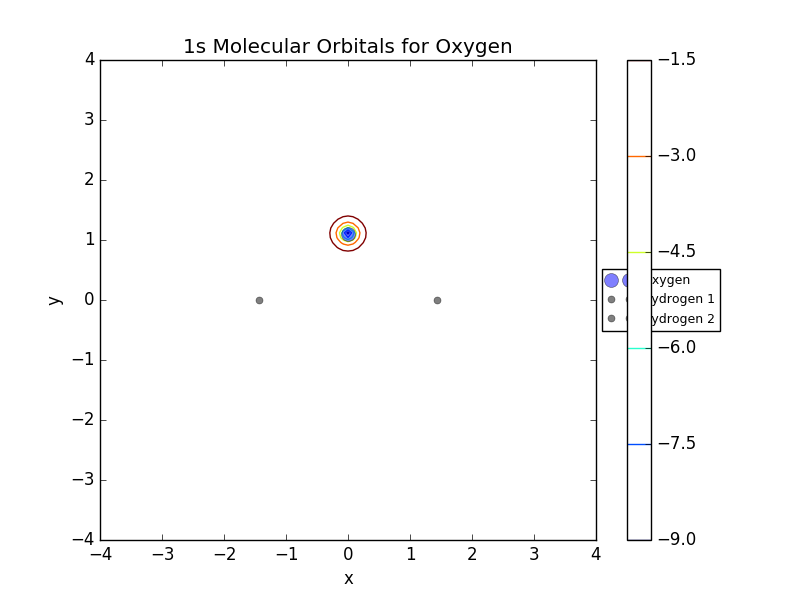

<IPython.core.display.Javascript object>


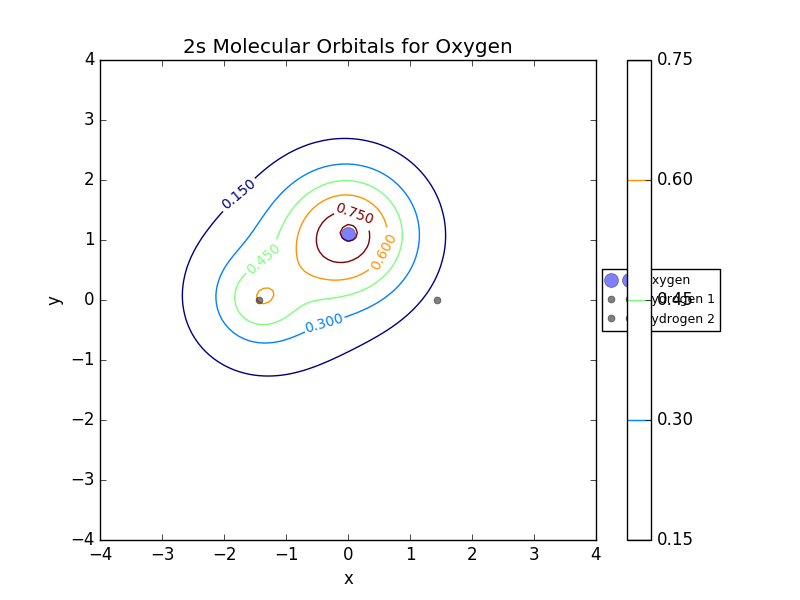

<IPython.core.display.Javascript object>


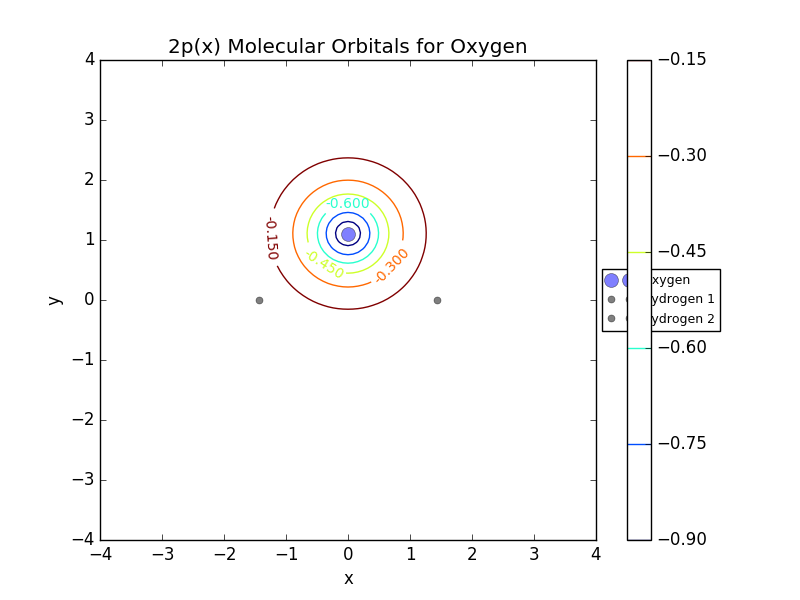

<IPython.core.display.Javascript object>


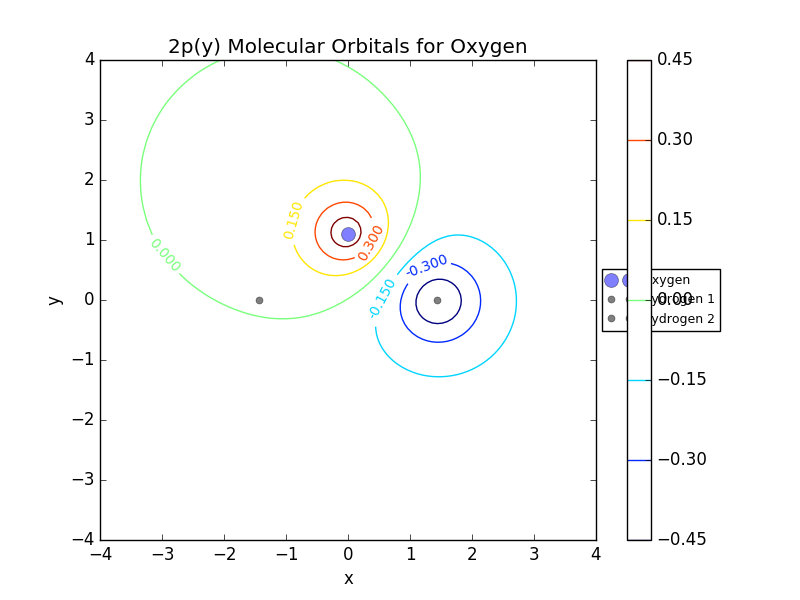

<IPython.core.display.Javascript object>


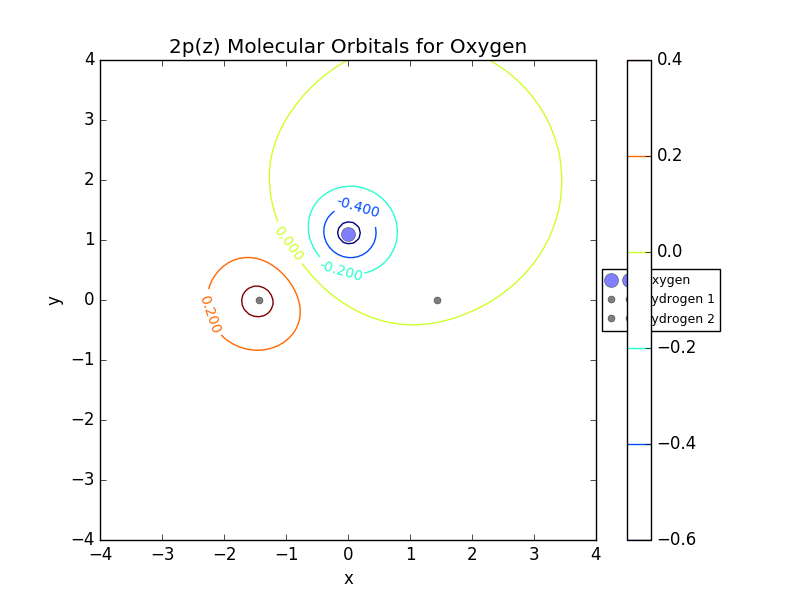

<IPython.core.display.Javascript object>


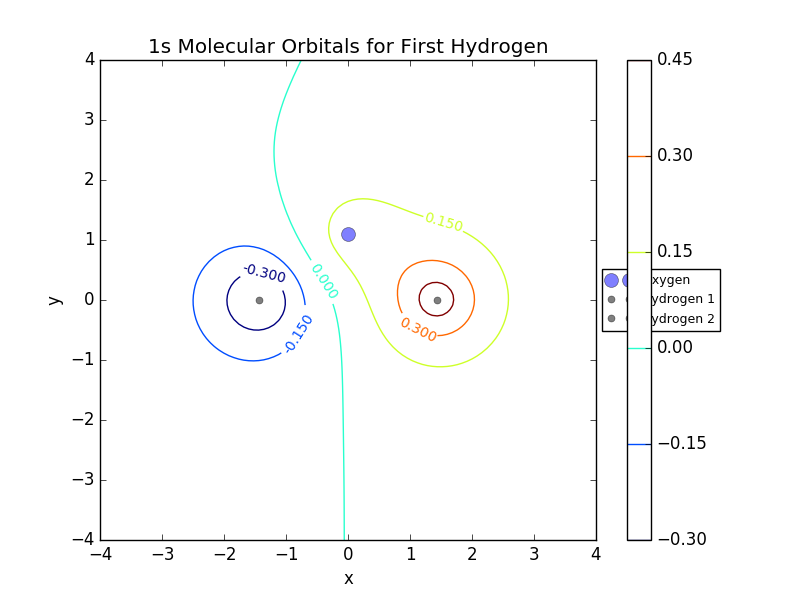

/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


<IPython.core.display.Javascript object>


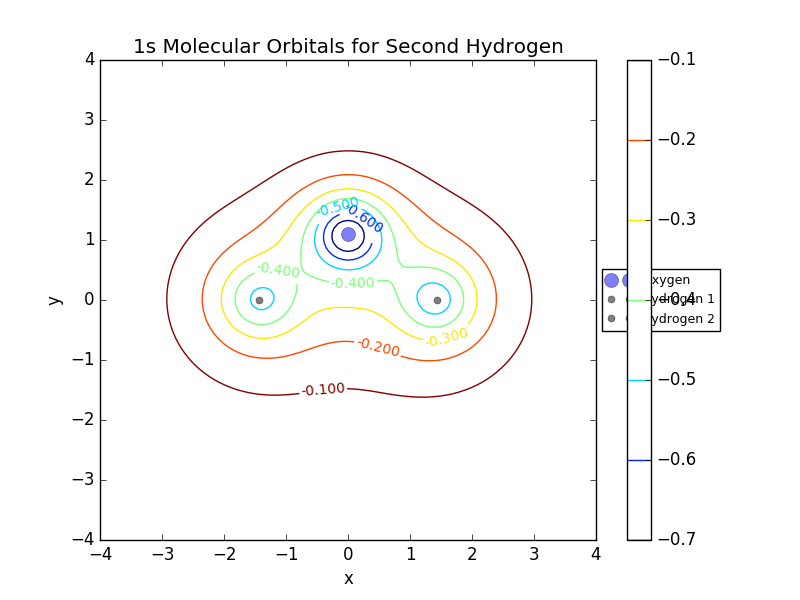

In [317]:
points = 100 # number of points in the grid
side = 4 # side length of the grid 
X = CHI_matrix(C, side, points) # calculate the orbitals
x = y = numpy.linspace(-side, side, points+1) # get the x & y axis

# list of titles for the plots
labels = ['1s Molecular Orbitals for Oxygen', 
          '2s Molecular Orbitals for Oxygen', 
          '2p(x) Molecular Orbitals for Oxygen', 
          '2p(y) Molecular Orbitals for Oxygen',
          '2p(z) Molecular Orbitals for Oxygen', 
          '1s Molecular Orbitals for First Hydrogen', 
          '1s Molecular Orbitals for Second Hydrogen']

# plot the graphs 
for i in range(C.shape[0]):
    fig = pyplot.figure(dpi=100)
    ax = fig.add_subplot(111)
    contoor = ax.contour(x, y, X[:,:,i], n_lines = 1000)
    ax.plot(R_O[0], R_O[1], 'bo', ms=10, label='Oxygen')
    ax.plot(R_H1[0], R_H1[1], 'ro', ms=5, label='Hydrogen 1')
    ax.plot(R_H2[0], R_H2[1], 'ro', ms=5, label='Hydrogen 2')
    ax.clabel(contoor, inline=1, fontsize=10)
    ax.legend(fontsize=9, loc='lower right', bbox_to_anchor=[1,0.5])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(labels[i])
    fig.colorbar(contoor)

In [311]:
def test_get_points():
    grid = get_points(2, 4)
    grid_test = numpy.array([[[-2., -2., 0.],
                              [-1., -2., 0.],
                              [ 0., -2., 0.],
                              [ 1., -2., 0.],
                              [ 2., -2., 0.]],
                             [[-2., -1., 0.],
                              [-1., -1., 0.],
                              [ 0., -1., 0.],
                              [ 1., -1., 0.],
                              [ 2., -1., 0.]],
                             [[-2.,  0., 0.],
                              [-1.,  0., 0.],
                              [ 0.,  0., 0.],
                              [ 1.,  0., 0.],
                              [ 2.,  0., 0.]],
                             [[-2.,  1., 0.],
                              [-1.,  1., 0.],
                              [ 0.,  1., 0.],
                              [ 1.,  1., 0.],
                              [ 2.,  1., 0.]],
                             [[-2.,  2., 0.],
                              [-1.,  2., 0.],
                              [ 0.,  2., 0.],
                              [ 1.,  2., 0.],
                              [ 2.,  2., 0.]]])
    assert type(grid) == numpy.ndarray, \
        "grid is not a numpy array"
    assert grid.shape == grid_test.shape, \
        "the grids have the same shape"
    assert numpy.allclose(grid, grid_test), \
        "the grid does not have the proper values. check that is was deployed properly."
    print("test get_points passed")


def test_make_coeff():
    coeffs = make_coeff()
    
    assert type(coeffs) == tuple or type(coeffs) == list, \
        "the return is not created well. it should be a list or tuple."
    assert coeffs[0].shape == (2,3), \
        "the first coeffs does not have proper shape."
    assert (coeffs[0] != 0).all(), \
        "no element should be 0"
    assert coeffs[1].shape == (3,2,3), \
        "coeffs_O was not properly created."
    assert (coeffs[1] != 0).all(), \
        "no element should be 0"
    print("test make_coeff passed")

    
def test_CHI_bar():
    coeff = make_coeff()
    coeffs = numpy.zeros((4, 2, 3))
    coeffs[0] = coeff[0]
    coeffs[1:] = coeff[1]
    
    for part in coeffs:
        r = numpy.random.random() * 10 - 5
        test_chi_bar = 0
        for j in range(3):
            test_chi_bar += part[0, j] * (2 * part[1, j] / numpy.pi)**0.75 * numpy.exp(-part[1, j] * r * r)
        chi_bar = CHI_bar(part, r)
        assert type(chi_bar) == float or type(chi_bar) == numpy.float64, \
            "chi_bar did not create a proper type value"
        assert numpy.allclose(chi_bar, test_chi_bar), \
            "Chi_bar did not compute proper values"
    print("chi_bar test passed")
    return test_chi_bar


def test_CHI_miu():
    xy = numpy.random.rand(3)
    coeff = make_coeff()
    X = numpy.zeros(7)
    r_o = numpy.linalg.norm(xy - R_O)
    r_h1 = numpy.linalg.norm(xy - R_H1)
    r_h2 = numpy.linalg.norm(xy - R_H2)
    for j in range(3):
        X[0] += coeff[1][0][0, j] * (2 * coeff[1][0][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[1][0][1, j] * r_o * r_o)
        X[1] += coeff[1][1][0, j] * (2 * coeff[1][1][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[1][1][1, j] * r_o * r_o)
        X[2] += coeff[1][2][0, j] * (2 * coeff[1][2][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[1][2][1, j] * r_o * r_o)
        X[3] += coeff[1][2][0, j] * (2 * coeff[1][2][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[1][2][1, j] * r_o * r_o)
        X[4] += coeff[1][2][0, j] * (2 * coeff[1][2][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[1][2][1, j] * r_o * r_o)
        X[5] += coeff[0][0, j] * (2 * coeff[0][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[0][1, j] * r_h1 * r_h1)
        X[6] += coeff[0][0, j] * (2 * coeff[0][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[0][1, j] * r_h2 * r_h2)
    CHI = CHI_miu(coeff, xy)
    assert CHI.shape[0] == 7, \
        "CHI_miu did not create the proper array"
    assert (CHI != 0).any(), \
        "everything is 0."
    assert numpy.allclose(CHI, X), \
        "CHI_miu has not created the values as expected."
    print("CHI_MIU test passed.")

def test_CHI_matrix():
    CHI = CHI_matrix(C, 2, 5)
    assert type(CHI) == numpy.ndarray, \
        "CHI is not the correct type."
    assert CHI.shape == (6, 6, 7), \
        "CHI_Matrix not the proper shape"
    assert (CHI != 0).any(), \
        "CHI is all 0."
    assert CHI.dtype == numpy.float64, \
        "CHI does not have the proper type inside."
        
    coeff = make_coeff()
    grid = get_points(2, 5)
    for test in range(10):
        x = numpy.random.randint(6)
        y = numpy.random.randint(6)
        X_miu = CHI_miu(coeff, grid[x, y])
        X = numpy.zeros(7)
        for i in range(7):
            X[i] = (C[i] * X_miu).sum()
        assert numpy.allclose(X, CHI[x, y]), \
            "Not correct values."
            
    print("CHI_matrix test passed")
        
def test_all_p2_p2():
    test_get_points()
    test_make_coeff()
    test_CHI_bar()
    test_CHI_miu()
    test_CHI_matrix()
    print("all tests passed.")

test_all_p2_p2()

test get_points passed
test make_coeff passed
chi_bar test passed
CHI_MIU test passed.
CHI_matrix test passed
all tests passed.
